<a href="https://colab.research.google.com/github/nikhilpillay/Kaggle-projects/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
nlp = spacy.load("en_core_web_sm")

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# Opening JSON file
f = open("/drive/MyDrive/complaints-2021-05-14_08_16.json", "r")

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
#print the column names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
#Assign new column names
df.rename(columns={'_source.tags':'tags',
                   '_source.zip_code':'zip_code',
                   '_source.complaint_id':'complaint_id',
                   '_source.issue':'issue',
                   '_source.date_received':'date_received',
                   '_source.state':'state',
                   '_source.consumer_disputed':'consumer_disputed',
                   '_source.product':'product',
                   '_source.company_response':'company_response',
                   '_source.company':'company',
                   '_source.submitted_via':'submitted_via',
                   '_source.date_sent_to_company':'date_sent_to_company',
                   '_source.company_public_response':'company_public_response',
                   '_source.sub_product':'sub_product',
                   '_source.timely':'timely',
                   '_source.complaint_what_happened':'complaint_what_happened',
                   '_source.sub_issue':'sub_issue',
                   '_source.consumer_consent_provided':'consumer_consent_provided'},
          inplace=True)

In [ ]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened']==''] = np.nan

In [ ]:
df.isna().sum()

_index                       57241
_type                        57241
_id                          57241
_score                       57241
tags                         74497
zip_code                     61886
complaint_id                 57241
issue                        57241
date_received                57241
state                        57384
consumer_disputed            57241
product                      57241
company_response             57241
company                      57241
submitted_via                57241
date_sent_to_company         57241
company_public_response      78311
sub_product                  59350
timely                       57241
complaint_what_happened      57241
sub_issue                    65417
consumer_consent_provided    57241
dtype: int64

In [ ]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint_what_happened'])

In [ ]:
df.isna().sum()

_index                           0
_type                            0
_id                              0
_score                           0
tags                         17256
zip_code                      4645
complaint_id                     0
issue                            0
date_received                    0
state                          143
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      21070
sub_product                   2109
timely                           0
complaint_what_happened          0
sub_issue                     8176
consumer_consent_provided        0
dtype: int64

In [ ]:
df.shape

(21072, 22)

In [ ]:
df.reset_index(inplace = True, drop = True)

In [ ]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower()
  text = re.sub(r"\[.*?\]", "", text)
  text = re.sub(r"[%s]" % re.escape(string.punctuation), "", text)
  text = re.sub(r"\w*\d\w*", "", text)

  return text


In [ ]:
sample = df.complaint_what_happened.sample().values[0]
print(sample)
print("----------------------------------------------------------------------")
cleanSample = clean_text(sample)
print(cleanSample)

Hi, I had applied for a loan modification through Chase Bank for my mortgage held by XXXX XXXX XX/XX/XXXX. I have had several SPOC ( single point of contact ) and been in touch with executive office as well as escalation department. This application was denied and I have since sent in a new application per advise from the executive office. I am having extreme trouble getting the correct information to help me with the process. Everything from, no phone calls and return calls from my SPOC, executive office, to verbal miss information about my modification qualifying or not. I could not get a solid answer of why I was denied. I was told I could n't get a modification because my property was n't owner occupied and then I could but needed more income. I feel Chase is violating OCC rules by not sending me this information in writing and not submitting a COMPLETE MODIFICATION PACKAGE which was complete XXXX/XXXX/XXXX and not being submitted until XXXX/XXXX/XXXX. In limbo for more than two mo

In [ ]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
  sentence = []
  doc = nlp(text)
  for word in doc:
    sentence.append(word.lemma_)

  return " ".join(sentence)

In [ ]:
print(cleanSample)
print("-----------------------------------")
lemmatizetext = lemmatize_text(cleanSample)
print(lemmatizetext)

hi i had applied for a loan modification through chase bank for my mortgage held by xxxx xxxx xxxxxxxx i have had several spoc  single point of contact  and been in touch with executive office as well as escalation department this application was denied and i have since sent in a new application per advise from the executive office i am having extreme trouble getting the correct information to help me with the process everything from no phone calls and return calls from my spoc executive office to verbal miss information about my modification qualifying or not i could not get a solid answer of why i was denied i was told i could nt get a modification because my property was nt owner occupied and then i could but needed more income i feel chase is violating occ rules by not sending me this information in writing and not submitting a complete modification package which was complete xxxxxxxxxxxx and not being submitted until xxxxxxxxxxxx in limbo for more than two months on xxxxxxxxxxxx a

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
from tqdm import tqdm
tqdm.pandas()
df_clean = pd.DataFrame()
df_clean["complaint"] = df["complaint_what_happened"].progress_apply(clean_text)

100%|██████████| 21072/21072 [00:04<00:00, 4596.96it/s]


In [ ]:
df_clean["lemmatized_complaint"] = df_clean["complaint"].progress_apply(lemmatize_text)

100%|██████████| 21072/21072 [17:58<00:00, 19.53it/s]


In [ ]:
print(df_clean.head())
print(df_clean.shape)

                                           complaint  \
0  good morning my name is xxxx xxxx and i apprec...   
1  i upgraded my xxxx xxxx card in  and was told ...   
2  chase card was reported on  however fraudulent...   
3  on  while trying to book a xxxx  xxxx  ticket ...   
4  my grand son give me check for  i deposit it i...   

                                lemmatized_complaint  
0  good morning my name be xxxx xxxx and I apprec...  
1  I upgrade my xxxx xxxx card in   and be tell b...  
2  chase card be report on   however fraudulent a...  
3  on   while try to book a xxxx   xxxx   ticket ...  
4  my grand son give I check for   I deposit it i...  
(21072, 2)


In [ ]:
#Write your function to extract the POS tags
from nltk import word_tokenize, pos_tag
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

def get_pos_tag(text):
  return pos_tag(word_tokenize(text))

def get_NN(text):
  NN =[]
  wordsWithTags = get_pos_tag(text)
  for word, tag in wordsWithTags:
    if(tag == "NN"):
      NN.append(word)

  return " ".join(NN)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
print(lemmatizetext)
print("-----------------------------")
print(get_pos_tag(lemmatizetext))
print("---------------------------")
lemmatizedTextPosRemoved = get_NN(lemmatizetext)
print(lemmatizedTextPosRemoved)

hi I have apply for a loan modification through chase bank for my mortgage hold by xxxx xxxx xxxxxxxx I have have several spoc   single point of contact   and be in touch with executive office as well as escalation department this application be deny and I have since send in a new application per advise from the executive office I be have extreme trouble get the correct information to help I with the process everything from no phone call and return call from my spoc executive office to verbal miss information about my modification qualifying or not I could not get a solid answer of why I be deny I be tell I could not get a modification because my property be not owner occupy and then I could but need more income I feel chase be violate occ rule by not send I this information in writing and not submit a complete modification package which be complete xxxxxxxxxxxx and not be submit until xxxxxxxxxxxx in limbo for more than two month on xxxxxxxxxxxx a representative xxxx read the note and

In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean["Complaint_POS_removed"] = df_clean["lemmatized_complaint"].progress_apply(get_NN)

100%|██████████| 21072/21072 [04:22<00:00, 80.25it/s]


In [ ]:
df_clean.head()

,complaint,lemmatized_complaint,Complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


In [ ]:
df_clean.shape

(21072, 3)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<Axes: xlabel='length of complaint', ylabel='Frequency'>

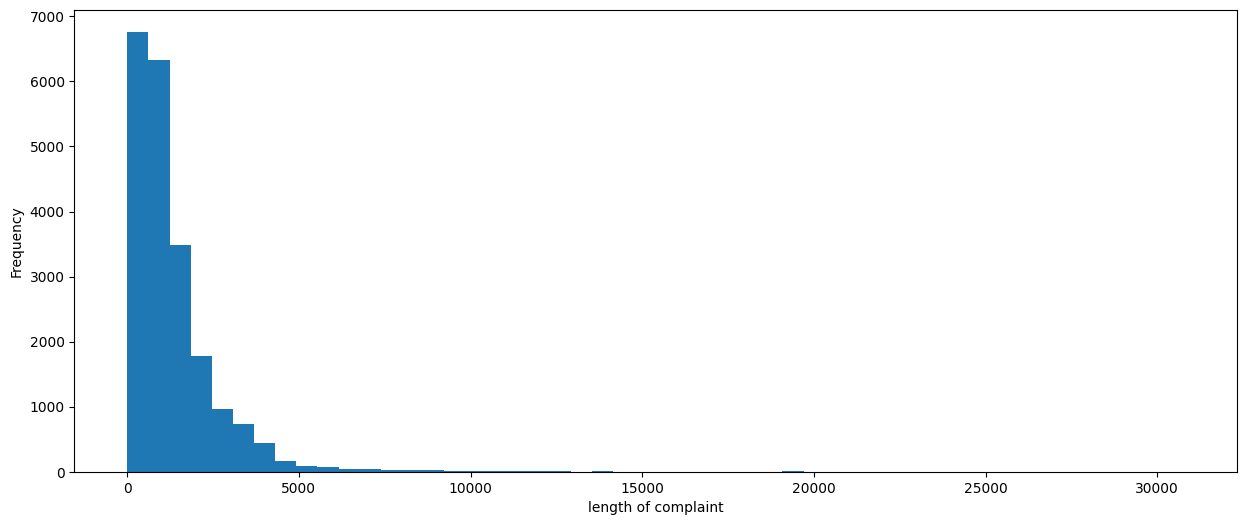

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.xlabel("length of complaint")
df_clean["complaint"].str.len().plot(kind = "hist", bins = 50, figsize = (15,6))

#### Find the top 40 words by frequency among all the articles after processing the text.

<function matplotlib.pyplot.show(close=None, block=None)>

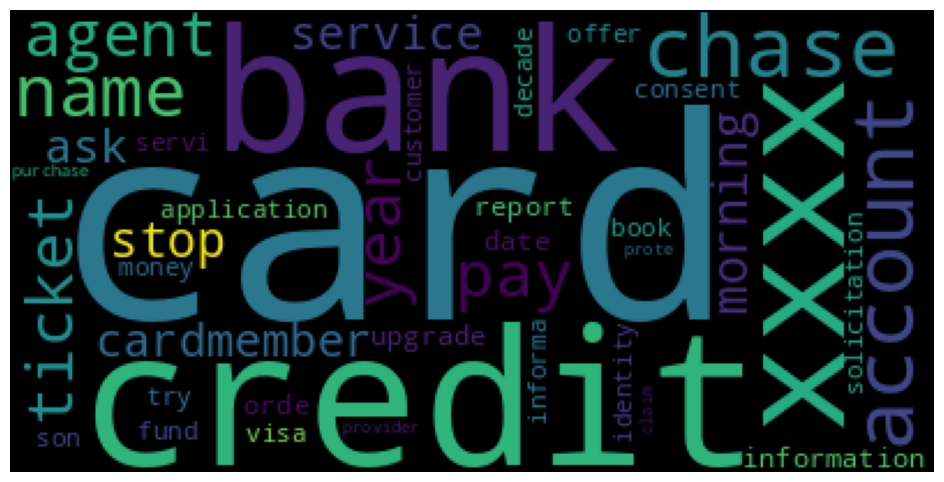

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
!pip install wordcloud
from wordcloud import WordCloud

wordCloud = WordCloud(max_words = 40).generate(str(df_clean.Complaint_POS_removed))
print(wordCloud)
plt.figure(figsize=(15,6))
plt.imshow(wordCloud)
plt.axis("off")
plt.show

In [ ]:
#top 40 words
print(list(wordCloud.words_.keys())[:40])

['card', 'credit', 'bank', 'xxxx', 'chase', 'account', 'name', 'agent', 'ticket', 'pay', 'year', 'morning', 'stop', 'cardmember', 'service', 'ask', 'upgrade', 'date', 'information', 'orde', 'report', 'application', 'identity', 'consent', 'servi', 'try', 'book', 'offer', 'informa', 'son', 'fund', 'money', 'customer', 'decade', 'solicitation', 'visa', 'provider', 'claim', 'purchase', 'prote']


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Removing -PRON- from the text corpus
df_clean["Complaint_clean"] = df_clean["Complaint_POS_removed"].str.replace("-PRON-", "")
df_clean.shape

(21072, 4)

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

def get_top_n_words(corpus, n=None):
  vec = CountVectorizer(stop_words = "english").fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x : x[1], reverse = True)
  return words_freq[:n]

common_words = get_top_n_words(df_clean["Complaint_clean"].values.astype("U"), 30)
df_unigram = pd.DataFrame(common_words, columns= ["unigram", "count"])

fig = go.Figure([go.Bar(x=df_unigram["unigram"], y = df_unigram["count"])])
fig.update_layout(title = go.layout.Title(text = "Top 30 unigrams in the cleaned complaint text"))
fig.show()



In [ ]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,account,47514
1,chase,46699
2,xxxx,36563
3,credit,34148
4,card,29278
5,bank,28403
6,payment,21166
7,time,16021
8,charge,14995
9,day,12972


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_bigram(corpus, n=None):
  vec = CountVectorizer(stop_words="english", ngram_range=(2,2)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x : x[1], reverse = True)
  return words_freq[:n]

common_words = get_top_n_bigram(df_clean["Complaint_clean"].values.astype("U"), 30)
df_bigram = pd.DataFrame(common_words, columns=["bigram", "count"])

fig = go.Figure([go.Bar(x=df_bigram['bigram'], y=df_bigram['count'])])
fig.update_layout(title=go.layout.Title(text='Top 30 bigram in the cleaned complaint text'))
fig.show()



In [ ]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12778
1,credit report,3955
2,xxxx xxxx,3953
3,customer service,3081
4,chase credit,2966
5,chase bank,2941
6,bank account,2729
7,account chase,2594
8,chase account,2564
9,check account,2414


In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_trigram(corpus, n=None):
  vec = CountVectorizer(stop_words = "english", ngram_range=(3,3)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x : x[1], reverse = True)
  return words_freq[:n]

common_words=get_top_n_trigram(df_clean['Complaint_clean'].values.astype('U'), 30)
df_trigram=pd.DataFrame(common_words, columns=['trigram', 'count'])

fig=go.Figure([go.Bar(x=df_trigram['trigram'], y=df_trigram['count'])])
fig.update_layout(title=go.layout.Title(text='Top 30 trigram in the cleaned complaint text'))
fig.show()



In [ ]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2063
1,credit card account,1022
2,credit card company,991
3,credit card chase,633
4,credit card credit,513
5,inquiry credit report,481
6,charge credit card,422
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,387


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

,complaint,lemmatized_complaint,Complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words="english", min_df = 2, max_df = 0.95)



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean["Complaint_clean"])
pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())

,aa,aarp,abandon,abandonment,abatement,abbreviation,abd,abide,ability,abovementione,...,yrs,ys,ytd,zelle,zero,zip,zipcode,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.159637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5


#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state = 40, max_iter = 500)
W = nmf_model.fit_transform(X)
H = nmf_model.components_


In [ ]:
#Print the Top15 words for each of the topics
words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index = [f"Topic {i+1}" for i in range(num_topics)], columns = [f"Word {i+1}" for i in range(15)]).astype(str)

for i in range(num_topics):
  ix = H[i].argsort()[::-1][:15]
  topic_words.iloc[i] = words[ix]

topic_words


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,year,balance
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay,credit,account,chase,year,mortgage
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,fraud,claim,purchase,service,time,statement,refund,company
Topic 5,loan,mortgage,home,modification,chase,property,year,letter,rate,time,document,bank,house,foreclosure,sale


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

df_topics = pd.DataFrame(W, columns = [i for i in range(num_topics) ])

df_topics["Topic"] = df_topics.apply(lambda x: x.idxmax(), axis = 1)
df_topics.head(5)

,0,1,2,3,4,Topic
0,0.022001,0.013025,0.006671,0.007554,0.021966,0
1,0.008843,0.014608,0.002214,0.012037,0.006042,1
2,0.000000,0.061476,0.000000,0.000000,0.000000,1
3,0.017942,0.063981,0.000000,0.005088,0.020494,1
4,0.070711,0.000000,0.000000,0.002555,0.007614,0


In [ ]:
df_topics.shape

(21072, 6)

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean["Topic"] = df_topics["Topic"]
df_clean.head()

,complaint,lemmatized_complaint,Complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [ ]:
df_clean.shape

(21072, 5)

In [ ]:
df_clean.head()

,complaint,lemmatized_complaint,Complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean_grouped = df_clean.groupby('Topic').head(5)
df_clean_grouped.sort_values('Topic')

,complaint,lemmatized_complaint,Complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
12,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


In [ ]:
print("Topic 0 ----------")
print(df_clean[df_clean['Topic'] == 0].values[0][0])
print("Topic 1 ----------")
print(df_clean[df_clean['Topic'] == 1].values[0][0])
print("Topic 2 ----------")
print(df_clean[df_clean['Topic'] == 2].values[0][0])
print("Topic 3 ----------")
print(df_clean[df_clean['Topic'] == 3].values[0][0])
print("Topic 4 ----------")
print(df_clean[df_clean['Topic'] == 4].values[0][0])

Topic 0 ----------
good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services 
in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt 
i have a right to know this information as a consumer 

chase account  xxxx xxxx xxxx xxxx thanks in advance for your help
Topic 1 ----------
i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
Topic 2 ----------
during the summer months i experience a decline income due to my employment therefore i request a one month payment extension wit

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:'Banking Services', 1:'Credit Card related Services',
               2:'Others', 3:'Fraud and Dispute', 4:'Mortgage and Loan Services'}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean.head(5)

,complaint,lemmatized_complaint,Complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Banking Services
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit Card related Services
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit Card related Services
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit Card related Services
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Banking Services


In [ ]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Banking Services":0,"Credit Card related Services":1,"Others":2,"Fraud and Dispute":3,"Mortgage and Loan Services":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean.head()

,complaint,lemmatized_complaint,Complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint", "Topic"]]


In [ ]:
training_data.head()

,complaint,Topic
0,good morning my name is xxxx xxxx and i apprec...,0
1,i upgraded my xxxx xxxx card in and was told ...,1
2,chase card was reported on however fraudulent...,1
3,on while trying to book a xxxx xxxx ticket ...,1
4,my grand son give me check for i deposit it i...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
#Write your code to get the Vector count
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data["complaint"])


#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)



You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size = 0.25, random_state = 40)



In [ ]:
print("X_train" ,X_train.shape)
print("y_train" ,y_train.shape)
print("X_test" ,X_test.shape)
print("y_test" ,y_test.shape)

X_train (15804, 33599)
y_train (15804,)
X_test (5268, 33599)
y_test (5268,)


In [ ]:
result_df = pd.DataFrame({"Original_Value": y_test})

#Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=40)
lr.fit(X_train,y_train)




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(multi_class='multinomial', random_state=40)

In [ ]:
y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)
clf_report = classification_report(y_test, y_pred)
print(" Acc on train", accuracy_score(y_train, y_pred_train))
print("Acc on test", accuracy_score(y_test, y_pred))
print(clf_report)

 Acc on train 0.9707668944570995
Acc on test 0.9236902050113895
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1300
           1       0.92      0.94      0.93      1236
           2       0.94      0.85      0.90       575
           3       0.90      0.91      0.91      1213
           4       0.94      0.93      0.94       944

    accuracy                           0.92      5268
   macro avg       0.93      0.92      0.92      5268
weighted avg       0.92      0.92      0.92      5268



In [ ]:
result_df["Logistic Regression"] = y_pred
result_df.head()

,Original_Value,Logistic Regression
3314,0,0
8270,3,3
13370,2,2
13270,0,0
20108,1,1


#Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state= 40)
params ={
    "max_depth" : [2,5,10],
    "min_samples_leaf" : [5,10,20],
    "min_samples_split" : [5,10,20]
}

grid_search = GridSearchCV(estimator = dt, param_grid = params, cv=3, n_jobs = -1, verbose = 10, scoring = "accuracy")

grid_result = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [ ]:
grid_result.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=5,
                       random_state=40)

In [ ]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=5,
                       random_state=40).fit(X_train, y_train)

In [ ]:
y_pred_train = dt.predict(X_train)
y_pred = dt.predict(X_test)
clf_report = classification_report(y_test, y_pred)
print(" Acc on train", accuracy_score(y_train, y_pred_train))
print("Acc on test", accuracy_score(y_test, y_pred))
print(clf_report)

 Acc on train 0.7951151607188054
Acc on test 0.7693621867881549
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1300
           1       0.81      0.81      0.81      1236
           2       0.80      0.73      0.76       575
           3       0.78      0.64      0.70      1213
           4       0.66      0.88      0.75       944

    accuracy                           0.77      5268
   macro avg       0.77      0.77      0.77      5268
weighted avg       0.78      0.77      0.77      5268



In [ ]:
result_df["Decision Tree"] = y_pred
result_df.head()

,Original_Value,Logistic Regression,Decision Tree
3314,0,0,0
8270,3,3,4
13370,2,2,2
13270,0,0,0
20108,1,1,1
